In [25]:
import torch
import torchvision
from torch import optim
from torchvision.models.detection import fasterrcnn_resnet50_fpn, FasterRCNN_ResNet50_FPN_V2_Weights, \
    fasterrcnn_resnet50_fpn_v2
from torchvision.datasets import VOCDetection
from torchvision.transforms import functional as F
from torch.utils.data import DataLoader
from tqdm import tqdm
from matplotlib import patches
import matplotlib.pyplot as plt


In [26]:
import numpy as np
from torchvision.datasets import OxfordIIITPet


class PetDataset(torch.utils.data.Dataset):
    def __init__(self, root, split="trainval"):
        self.dataset = OxfordIIITPet(
            root=root,
            split=split,
            target_types="segmentation",
            download=True
        )

    def __getitem__(self, idx):
        img, mask = self.dataset[idx]
        img = F.to_tensor(img)

        mask = np.array(mask)
        binary_mask = mask == 1

        if binary_mask.sum() == 0:
            # αν δεν υπάρχει object, παραλείπουμε
            return self[(idx+1) % len(self)]

        binary_mask = torch.as_tensor(binary_mask, dtype=torch.float32)

        pos = torch.where(binary_mask)
        xmin = torch.min(pos[1])
        xmax = torch.max(pos[1])
        ymin = torch.min(pos[0])
        ymax = torch.max(pos[0])

        boxes = torch.tensor([[xmin, ymin, xmax, ymax]], dtype=torch.float32)
        labels = torch.ones((1,), dtype=torch.int64)
        masks = binary_mask.unsqueeze(0).float()  # float tensor

        target = {
            "boxes": boxes,
            "labels": labels,
            "masks": masks
        }

        return img, target


    def __len__(self):
        return len(self.dataset)

In [27]:
def collate_fn(batch):
    return tuple(zip(*batch))


train_dataset = PetDataset("./data", split="trainval")
val_dataset = PetDataset("./data", split="test")

from torch.utils.data import Subset
train_dataset = Subset(train_dataset, range(300))
val_dataset = Subset(val_dataset, range(50))


train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=collate_fn, num_workers=0, pin_memory=True, persistent_workers=False)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False, collate_fn=collate_fn)

In [28]:
def train_one_epoch(model, loader, optimizer, device, epoch, epochs):
    model.train()
    running_loss = 0

    pbar = tqdm(loader, desc=f"Epoch {epoch+1}/{epochs} [Train]", leave=False)

    for images, targets in pbar:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        # σε περίπτωση που επιστραφεί list αντί για dict
        if isinstance(loss_dict, list):
        # παίρνουμε το πρώτο στοιχείο
            loss_dict = loss_dict[0]
        loss = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        pbar.set_postfix(loss=loss.item())

    return running_loss / len(loader)


In [29]:
def train_model(model, train_loader, optimizer, device, epochs):
    history = {
        "train_loss": [],
        "map": [],
        "map_50": []
    }

    for epoch in range(epochs):
        train_loss = train_one_epoch(
            model, train_loader, optimizer, device, epoch, epochs
        )

        history["train_loss"].append(train_loss)
        map_res = evaluate_map(model, val_loader, device)
        history["map"].append(map_res["map"].item())
        history["map_50"].append(map_res["map_50"].item())

        print(
            f"Epoch {epoch+1}/{epochs} | "
            f"Train Loss: {train_loss:.4f} | "
            f"mAP: {map_res['map']:.4f} | "
            f"m50: {map_res['map_50']:.4f} | "
        )

    return history


In [30]:
def plot_curves(results):
    fig, axes = plt.subplots(1,3, figsize=(18,5))

    for name, hist in results.items():

        if "train_loss" in hist:
            axes[0].plot(hist["train_loss"], label=f"{name} Train")

        if "map" in hist:
            axes[1].plot(hist["map"], label=f"{name} MAP")

        if "map_50" in hist:
            axes[2].plot(hist["map_50"], label=f"{name} MAP 50")


    axes[0].set_title("Training Loss")
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Loss")
    axes[0].grid(True)
    axes[0].legend()

    axes[1].set_title("mAP")
    axes[1].set_xlabel("Epoch")
    axes[1].grid(True)
    axes[1].legend()

    axes[2].set_title("mAP@0.5")
    axes[2].set_xlabel("Epoch")
    axes[2].grid(True)
    axes[2].legend()

    plt.tight_layout()
    plt.show()

In [31]:
def show_detection(model, dataset, device, n):
    model.eval()

    import random
    idxs = random.sample(range(len(dataset)), n)

    for idx in idxs:
        img, target = dataset[idx]

        with torch.no_grad():
            pred = model([img.to(device)])[0]

        img_np = img.permute(1,2,0).cpu().numpy()

        plt.figure(figsize=(6,6))
        plt.imshow(img_np)
        ax = plt.gca()

        # GT boxes (green)
        for box in target["boxes"]:
            x1,y1,x2,y2 = box
            rect = patches.Rectangle((x1,y1), x2-x1, y2-y1,
                                     linewidth=2, edgecolor='g', facecolor='none')
            ax.add_patch(rect)

        # Pred boxes (red)
        if len(pred["scores"]) > 0:
            best_idx = pred["scores"].argmax()
            box = pred["boxes"][best_idx]

            x1,y1,x2,y2 = box.cpu()
            rect = patches.Rectangle((x1,y1), x2-x1, y2-y1,
                                     linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)

        plt.title("Green=GT, Red=Prediction")
        plt.axis("off")
        plt.show()


In [32]:
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

def create_model(num_classes, device):
    # φορτώνουμε προεκπαιδευμένο Mask R-CNN
    model = maskrcnn_resnet50_fpn(weights="DEFAULT")

    # αντικαθιστούμε τον predictor για το class+box
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(
        in_features, num_classes
    )

    # αντικαθιστούμε και τον mask predictor για τον αριθμό των classes
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    model.roi_heads.mask_predictor = MaskRCNNPredictor(
        in_features_mask, hidden_layer, num_classes
    )

    return model.to(device)


In [33]:
from torchmetrics.detection.mean_ap import MeanAveragePrecision

def evaluate_map(model, loader, device):
    model.eval()
    metric = MeanAveragePrecision(iou_type="bbox")

    with torch.no_grad():
        for images, targets in loader:
            images = [img.to(device) for img in images]
            preds = model(images)

            preds = [{k: v.cpu() for k, v in p.items()} for p in preds]
            targets = [{k: v.cpu() for k, v in t.items()} for t in targets]

            metric.update(preds, targets)

    return metric.compute()


In [34]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


Training with epochs=5


Epoch 1/5 | Train Loss: 0.4889 | mAP: 0.5316 | m50: 0.9699 | 


Epoch 2/5 | Train Loss: 0.2824 | mAP: 0.6349 | m50: 0.9948 | 


Epoch 3/5 | Train Loss: 0.2354 | mAP: 0.6946 | m50: 0.9919 | 


Epoch 4/5 | Train Loss: 0.2077 | mAP: 0.6636 | m50: 0.9840 | 


Epoch 5/5 | Train Loss: 0.1929 | mAP: 0.7207 | m50: 0.9910 | 
Epochs: 5, LR: 0.001
mAP: 0.7207192182540894
mAP@0.5: 0.9909923076629639


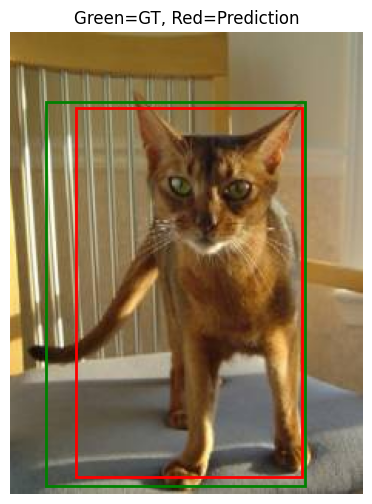

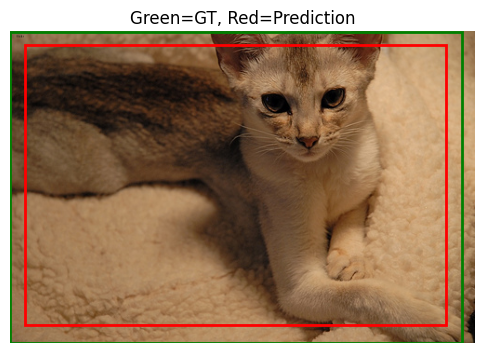

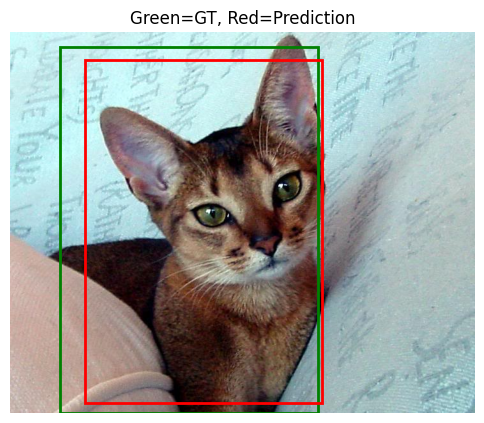

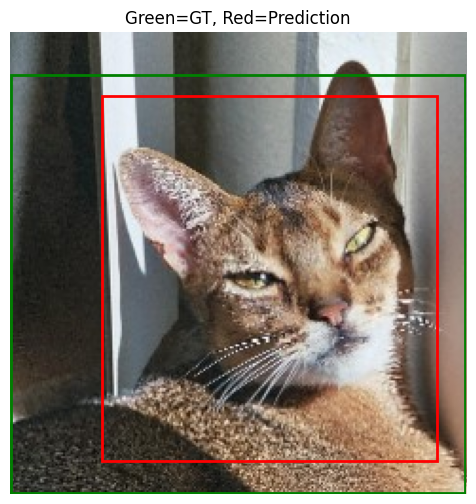

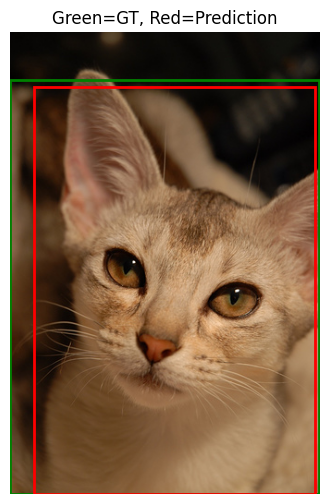

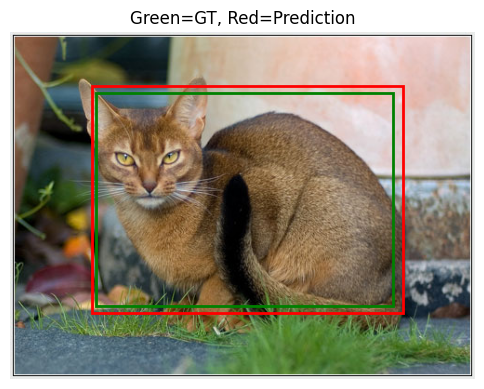

Training with epochs=10


Epoch 1/10 | Train Loss: 0.4899 | mAP: 0.3339 | m50: 0.7761 | 


Epoch 2/10 | Train Loss: 0.2961 | mAP: 0.6088 | m50: 0.9956 | 


Epoch 3/10 | Train Loss: 0.2413 | mAP: 0.6353 | m50: 0.9785 | 


Epoch 4/10 | Train Loss: 0.2138 | mAP: 0.6658 | m50: 0.9953 | 


Epoch 5/10 | Train Loss: 0.1975 | mAP: 0.6914 | m50: 0.9958 | 


Epoch 6/10 | Train Loss: 0.1860 | mAP: 0.7155 | m50: 1.0000 | 


Epoch 7/10 | Train Loss: 0.1749 | mAP: 0.7178 | m50: 0.9965 | 


Epoch 8/10 | Train Loss: 0.1702 | mAP: 0.7227 | m50: 0.9977 | 


Epoch 9/10 | Train Loss: 0.1631 | mAP: 0.7026 | m50: 0.9977 | 


Epoch 10/10 | Train Loss: 0.1570 | mAP: 0.7177 | m50: 0.9959 | 
Epochs: 10, LR: 0.001
mAP: 0.7177115678787231
mAP@0.5: 0.9959231019020081


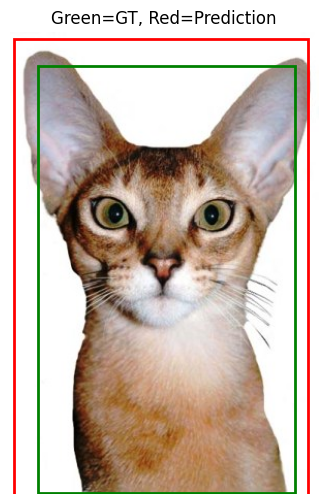

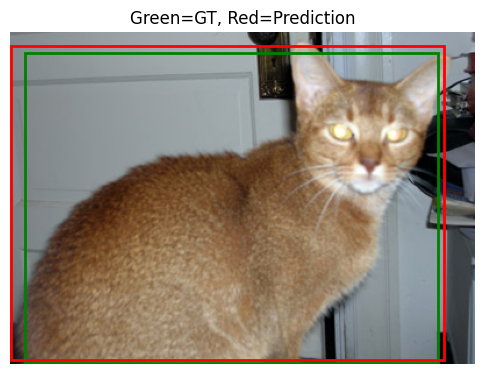

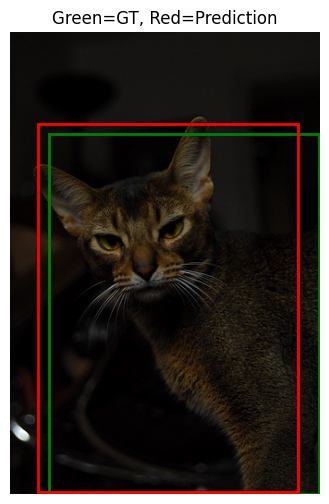

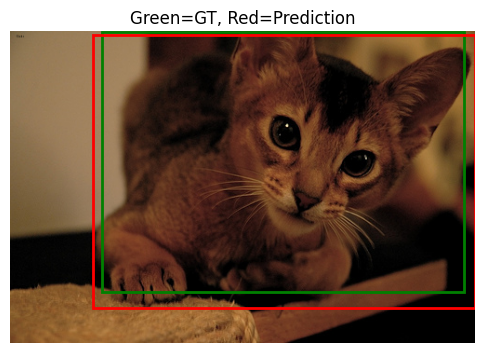

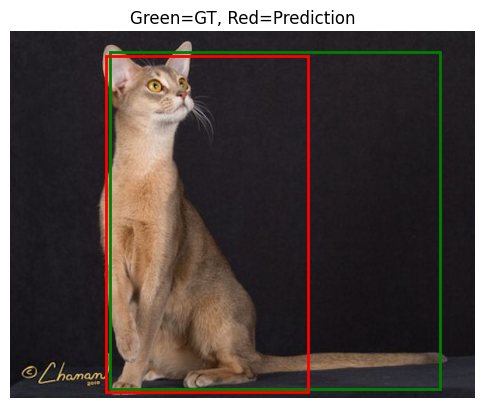

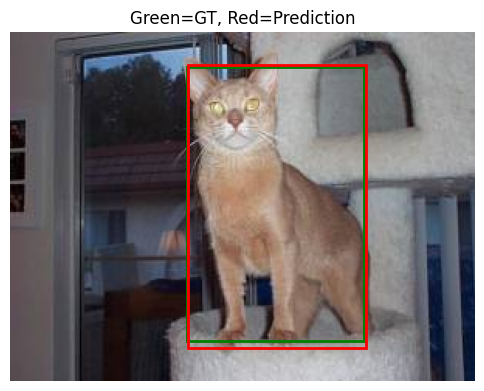

Training with epochs=15


Epoch 1/15 | Train Loss: 0.5675 | mAP: 0.3113 | m50: 0.7497 | 


Epoch 2/15 | Train Loss: 0.3506 | mAP: 0.4979 | m50: 0.9416 | 


Epoch 3/15 | Train Loss: 0.2755 | mAP: 0.5596 | m50: 0.9784 | 


Epoch 4/15 | Train Loss: 0.2409 | mAP: 0.6005 | m50: 0.9994 | 


Epoch 5/15 | Train Loss: 0.2172 | mAP: 0.6338 | m50: 0.9806 | 


Epoch 6/15 | Train Loss: 0.1981 | mAP: 0.6505 | m50: 0.9989 | 


Epoch 7/15 | Train Loss: 0.1863 | mAP: 0.6745 | m50: 0.9903 | 


Epoch 8/15 | Train Loss: 0.1778 | mAP: 0.7074 | m50: 0.9938 | 


Epoch 9/15 | Train Loss: 0.1723 | mAP: 0.6855 | m50: 0.9937 | 


Epoch 10/15 | Train Loss: 0.1653 | mAP: 0.7016 | m50: 0.9967 | 


Epoch 11/15 | Train Loss: 0.1598 | mAP: 0.6969 | m50: 1.0000 | 


Epoch 12/15 | Train Loss: 0.1544 | mAP: 0.7187 | m50: 0.9933 | 


Epoch 13/15 | Train Loss: 0.1512 | mAP: 0.6906 | m50: 0.9935 | 


Epoch 14/15 | Train Loss: 0.1469 | mAP: 0.7137 | m50: 0.9909 | 


Epoch 15/15 | Train Loss: 0.1427 | mAP: 0.6944 | m50: 0.9935 | 
Epochs: 15, LR: 0.001
mAP: 0.6944147944450378
mAP@0.5: 0.9934825301170349


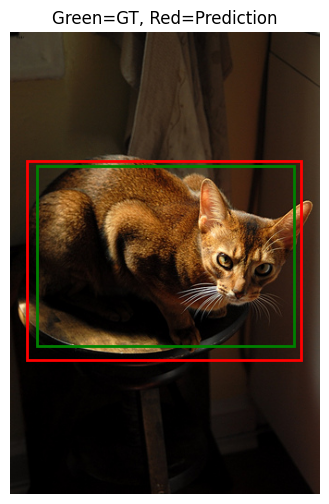

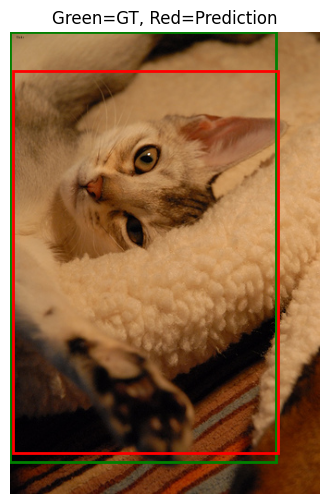

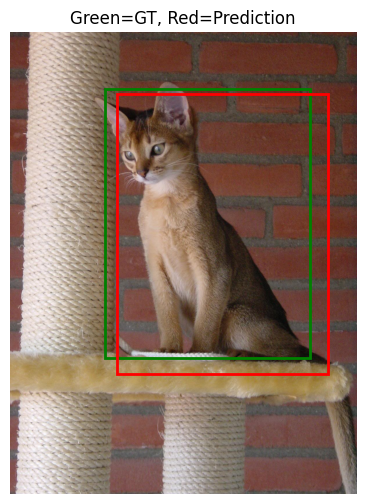

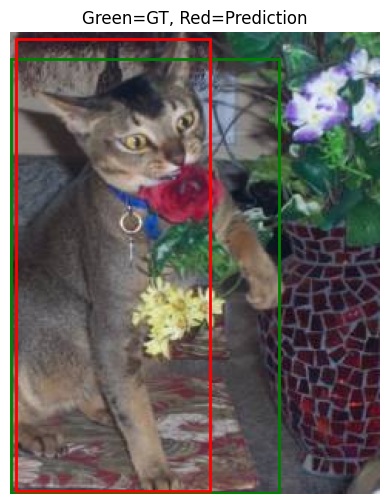

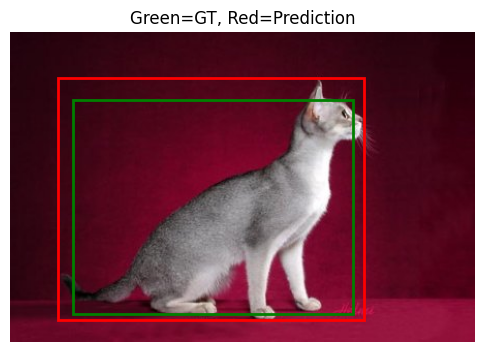

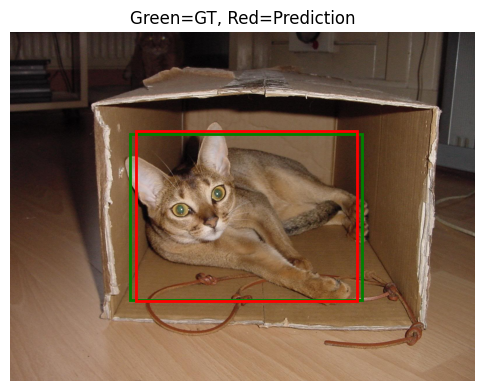

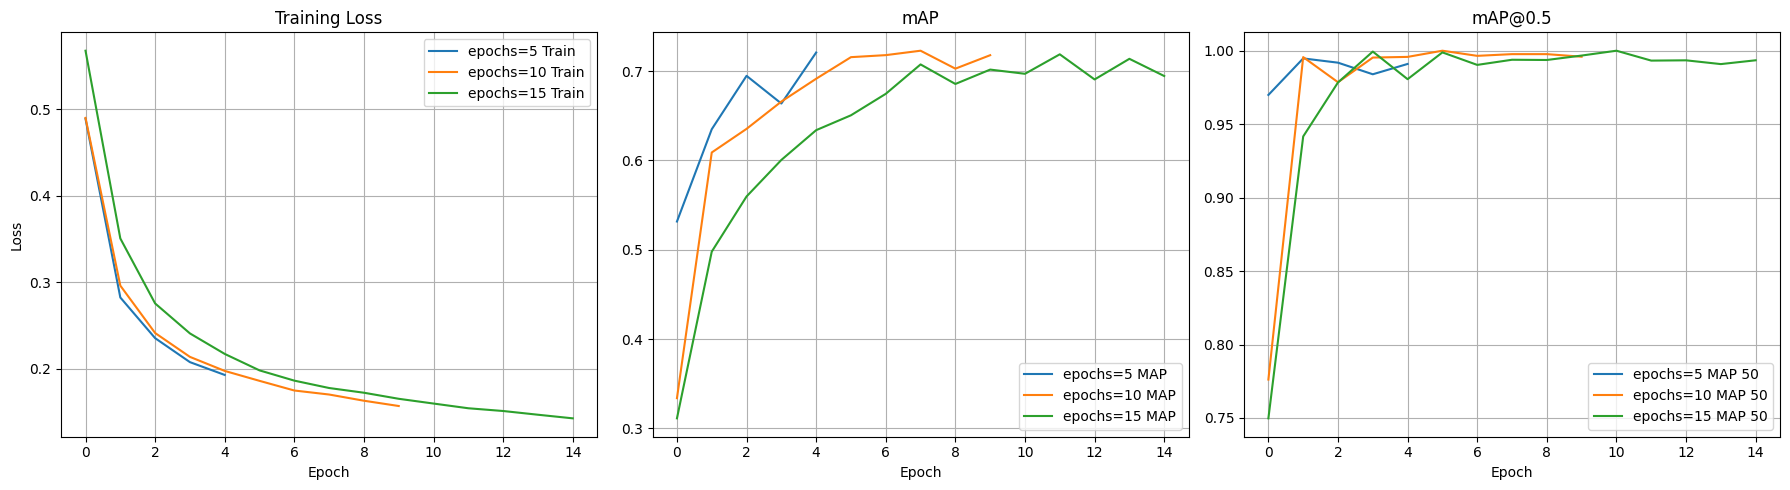

In [35]:
results = {}
lr = 1e-3

for epochs in [5, 10, 15]:
    print(f"Training with epochs={epochs}")

    model = create_model(num_classes=2, device=device)

    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

    history = train_model(model, train_loader, optimizer, device, epochs)
    map_results = evaluate_map(model, val_loader, device)

    print(f"Epochs: {epochs}, LR: {lr}")
    print("mAP:", map_results["map"].item())
    print("mAP@0.5:", map_results["map_50"].item())

# 3️⃣ VISUAL RESULTS
    show_detection(model, val_dataset, device, n=6)

    results[f"epochs={epochs}"] = history

plot_curves(results)

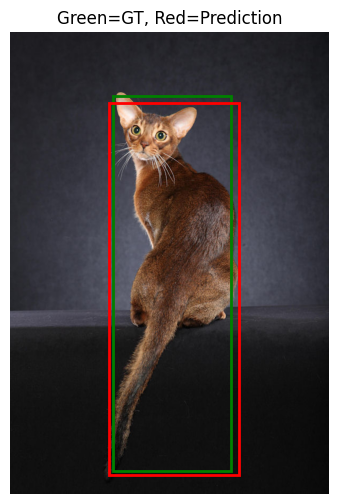

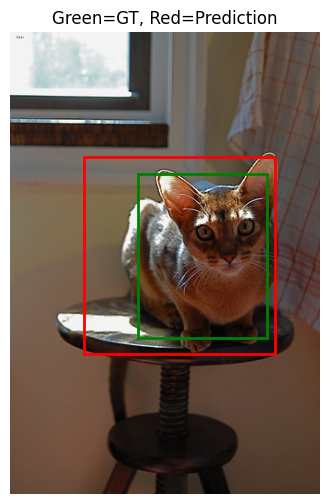

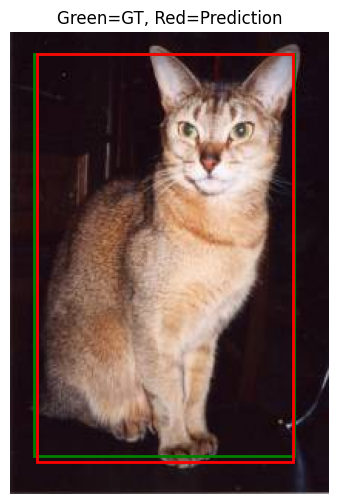

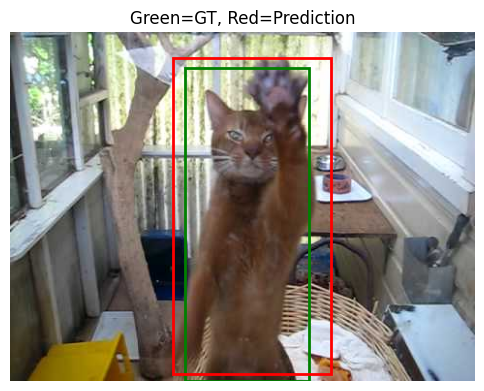

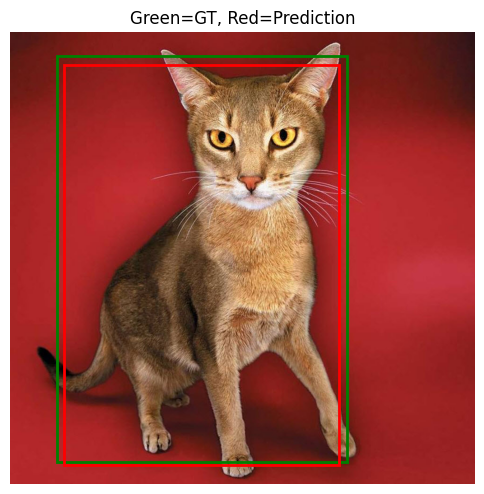

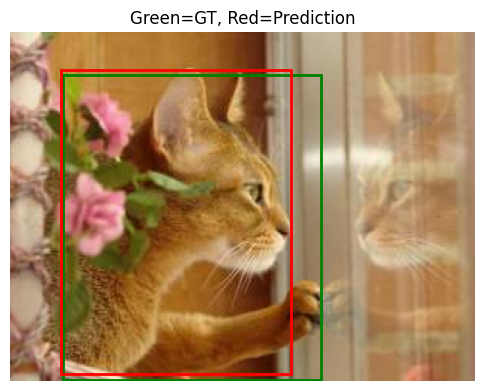

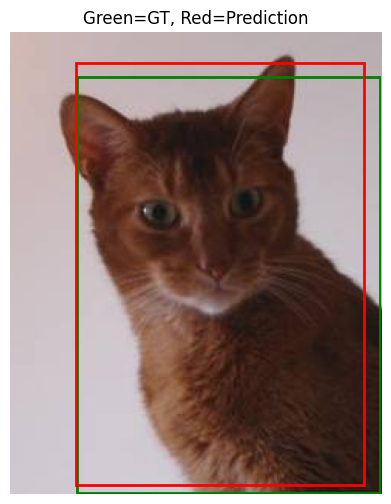

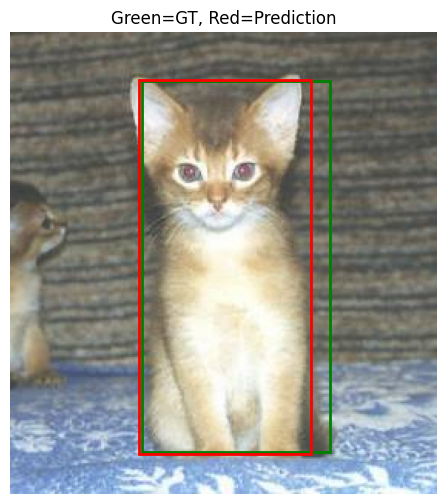

In [36]:
show_detection(model, val_dataset, device, n=8)